In [1]:
#TODO: extend to multiple variables 

# Imports
import cartopy
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
import iris.coord_categorisation
from iris.util import rolling_window
from ruamel import yaml
from tqdm import tqdm
from ruamel.yaml import ruamel
import warnings

import os

In [2]:
# test for multi model execution, 5 first tier ISIMIP models:

def filepath_generator(basepath,scenario,model):
    return basepath+'/'+scenario+'/output/data_'+model+'.yml'

modellist = [
'gfdl-esm4',
'ipsl-cm6a-lr',
'mpi-esm1-2-hr',
'mri-esm2-0',
'ukesm1-0-ll']
basepath = '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/'
data_dictionary = {}
for i_model in modellist:
    data_dictionary [i_model,'historical']= filepath_generator(basepath,'historical',i_model)
    data_dictionary [i_model,'ssp126']= filepath_generator(basepath,'ssp126',i_model)
    data_dictionary [i_model,'ssp370']= filepath_generator(basepath,'ssp370',i_model)
    data_dictionary [i_model,'ssp585']= filepath_generator(basepath,'ssp585',i_model)


# generate dictionary of  data [model,scenario]

# get all keys from dictionary
data_keys = data_dictionary.keys()
filepaths = {}
for i_key in data_keys:
    with open(data_dictionary[i_key], 'r') as stream:
            try:
                filepaths[i_key] = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
print(filepaths)

{('gfdl-esm4', 'historical'): ['/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_20012010.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_19811990.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_19011910.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_18811890.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_19511960.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_18711880.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_19711980.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_18911900.nc', '/p/tmp/quante/snow_simulation_data/isimip3b/20200406_all_models/historical/output_gfdl-esm4_18501850.nc', '/p/tm

In [3]:

# functions to filter for specific variables, add seasons etc

def filter_cube (cube,variablename):
    return cube.extract(variablename)
   
# constrain cubelists

def latitude_constraint(latitude,cube):
    # restrict on latitudes above northern tropic
    latitudeConstraint = iris.Constraint(latitude=lambda v: latitude <= v)
    return cube.extract(latitudeConstraint)

def add_seasons (cubelist):
    for i_cube in cubelist:
        iris.coord_categorisation.add_season(i_cube, 'time', name='season')
        iris.coord_categorisation.add_season_year(i_cube, 'time', name='season_year')
    return cubelist

# concatenate all cubes by time
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes 
def unify_concatenate(cubelist):
    unify_time_units(cubelist)
    equalise_attributes(cubelist)
    
    return cubelist.concatenate_cube()  

# add area bounds to enable area weighted mean:
def add_lon_lat_bounds (cube):
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()

# filter for specific season
def filter_season(cube,season):
    season_constr = iris.Constraint(season=season)
    return cube.extract(season_constr)
        
    
def prepare_season_stats(cubedict,season):
    keys = cubedict.keys()
    season_dict = {}
    for i_key in keys:
        season_cube = filter_season(cubedict[i_key],season)
        season_dict [i_key]    = season_cube                                     
    return season_dict


In [4]:
# load data

variablename = "approx_fresh_daily_snow_height"
cubelist = {}

for i_key in data_keys:
    cubelist[i_key] = (latitude_constraint(23,iris.load(filepaths[i_key],variablename)))
    
for i_key in data_keys: 
    print(i_key)
    print(cubelist[i_key])

# ignore warnings
warnings.simplefilter("ignore")

('gfdl-esm4', 'historical')
0: approx_fresh_daily_snow_height / (1) (time: 365; latitude: 134; longitude: 720)
1: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)
2: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
3: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)
4: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
5: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
6: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
7: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)
8: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
9: approx_fresh_daily_snow_height / (1) (time: 3653; latitude: 134; longitude: 720)
10: approx_fresh_daily_snow_height / (1) (time: 3652; latitude: 134; longitude: 720)
11: approx_fresh_daily_snow_height / (1) (time: 

In [5]:
# generate extra cube of decade 2011 to 2020 (with ssp585 data)
def unify_current_decade (model):

    cubes_to_concatenate = iris.cube.CubeList()
    cubes_to_concatenate.append(cubelist[model, 'historical'][17])
    cubes_to_concatenate.append(cubelist[model, 'ssp585'][0])

    cube_2011_2020 = unify_concatenate(cubes_to_concatenate)
    cubelist[model, 'historical'][17]=cube_2011_2020
    


In [6]:
for i_model in modellist:
    unify_current_decade(i_model)

In [37]:
def extract_dates(cube,startyear,finalyear):
    
    # filter for certain years (inclusive for start and final year)
    # add auxilary year coordinate

    iris.coord_categorisation.add_year(cube, 'time', name='year')
    year_constraint = iris.Constraint(year= lambda t: startyear<=t<=finalyear)
    limited_cube = cube.extract(year_constraint)
    cube.remove_coord('year')
    return limited_cube
# method to generate flattened array of data from a cube

def flattened_data_array (cube):
    # get data as numpy array
    np_data = cube.data
    #return flattened data
    return np_data.flatten()

def generate_quantile_exceedance_development (cube,quantiles,startyear,finalyear,intensity=False):

    data_timeperiod = extract_dates(cube,startyear,finalyear)

    # calculate exceedance of quantiles for each gridcell to use as thresholds:

    data = {}
    for i_quantile in quantiles:
        quantile_data = data_timeperiod.collapsed('time',iris.analysis.PERCENTILE,percent=i_quantile)
    
        exceedance = data_timeperiod - quantile_data
        # consider only positve values of exceedance
        exceedance_array = exceedance.data
        exceedance_indicators =(exceedance_array  > 0)
        
        exceedance.data = exceedance_array * exceedance_indicators
        
        number_exceedances = exceedance.collapsed('time',iris.analysis.COUNT,function= lambda x: x>0)
        sum_exceedances = exceedance.collapsed('time',iris.analysis.SUM)
        
        mean_exceedance = sum_exceedances / number_exceedances
        
        data ['quantile',i_quantile] = quantile_data
        data ['exceedance',i_quantile] = exceedance
        data [number_exceedances] = number_exceedances
        data ['mean_exceedance',i_quantile]=mean_exceedance
    return data
    
    
def generate_threshold_development (cube,startyear,finalyear,intensity=False):

    cube_years = extract_dates(cube,startyear,finalyear)
    
    
   

    # general threshold specs
    
    start_threshold = 500
    threshold_step = 5
    final_threshold = 1500
    thresholds = np.arange(start_threshold,final_threshold+threshold_step,threshold_step)
    # calculate exceedance cubes for plotting of maps etc
    
    map_threshold_step = 250
    map_thresholds = np.arange(start_threshold,final_threshold+map_threshold_step,map_threshold_step)
    threshold_cubes = {}
    for i_threshold in map_thresholds:
        threshold_cubes[str(i_threshold),'frequency']= cube_years.collapsed('time',iris.analysis.COUNT,function = lambda x: x>i_threshold)
        # calcuclate intensity for each gridcell:
       
        
        frequency_data=threshold_cubes[str(i_threshold),'frequency'].data
        clipped_data= np.clip(cube_years.data,a_min=i_threshold,a_max=None)
        clipped_data = np.subtract(clipped_data,i_threshold)
        intensity_data = np.sum(clipped_data,axis=0)
        
       
        expected_snowfall_data = intensity_data/frequency_data
        
        expected_snowfall_cube = threshold_cubes[str(i_threshold),'frequency'].copy(data=expected_snowfall_data) 

        var_name= ('expected_snowfall_above_'+str(i_threshold)+'mm_per_day')
        expected_snowfall_cube.var_name = var_name
        threshold_cubes[str(i_threshold),'expected_snowfall'] = expected_snowfall_cube
        threshold_cubes[str(i_threshold),'intensity'] = intensity_data
    dataarray = flattened_data_array(cube_years)
    thresholds = np.arange(start_threshold,final_threshold+threshold_step,threshold_step)
    exceedances = np.empty(thresholds.size)
    if intensity:
        intensities = np.empty(thresholds.size)
        
    # count number of events above threshold for all thresholds
    index_array = 0
    for i_threshold in thresholds:
        exceedances[index_array]=count_threshold_exceedances(dataarray,i_threshold)
        if intensity:
            intensities[index_array] = np.sum(dataarray[dataarray>i_threshold])
        index_array +=1
    data = {}
    data ['exceedance_array'] = np.vstack((thresholds,exceedances))
    if intensity:
        data ['intensity_array'] = np.vstack((thresholds,intensities))
    data ['map_cubes']=threshold_cubes
    return data
    
def count_threshold_exceedances (dataarray,threshold):
    
    return (dataarray[dataarray>threshold].size) 

In [8]:
def calculate_decades_threshold_frequency (historical_cube,ssp126_cube,ssp370_cube,ssp585_cube,number_of_decades,historical_start,ssp_start,intensity=False):
    
    return calculate_timespans_threshold_frequency (historical_cube,ssp126_cube,ssp370_cube,ssp585_cube,10,number_of_decades,historical_start,ssp_start,intensity=intensity)


def calculate_timespans_threshold_frequency (historical_cube,ssp126_cube,ssp370_cube, ssp585_cube,number_of_years_to_compare,number_of_timeperiods,historical_start,ssp_start,intensity=False):
    historical_start_list = []
   
    historical_start_list.append(historical_start)

    
    ssp_start_list = []
    
    ssp_start_list.append(ssp_start)
    
    

    for index in range(1, number_of_timeperiods):
        historical_start_list.append(historical_start_list [index-1]+number_of_years_to_compare)
        
        ssp_start_list.append(ssp_start_list [index-1]+number_of_years_to_compare)
      

    

    data = {}
    
    for i_historical_start in historical_start_list:
        i_historical_end = i_historical_start+number_of_years_to_compare-1
        data ['historical',i_historical_start,i_historical_end] = generate_threshold_development(historical_cube,i_historical_start,i_historical_end,intensity=intensity)

    for i_ssp_start in ssp_start_list:
        i_ssp_end = i_ssp_start+number_of_years_to_compare-1
        data ['ssp126',i_ssp_start,i_ssp_end] = generate_threshold_development(ssp126_cube,i_ssp_start,i_ssp_end,intensity=intensity)
        data ['ssp370',i_ssp_start,i_ssp_end] = generate_threshold_development(ssp370_cube,i_ssp_start,i_ssp_end,intensity=intensity)
        data ['ssp585',i_ssp_start,i_ssp_end] = generate_threshold_development(ssp585_cube,i_ssp_start,i_ssp_end,intensity=intensity)

    
    return (data)

In [9]:
# function to restrict cubes on bounding box

def cube_from_bounding_box (cube, bounding_box):
    return cube.intersection(longitude=(bounding_box[0],bounding_box[2])).intersection(latitude=(bounding_box[1],bounding_box[3]))


def country_dict_from_iso(country):
    country_dict = {}
    for c in country_subunits_by_iso_code(country):
        print (c.name)
        country_dict[str(c.name)]=c.bbox
    return country_dict



# method to create list of country limited cubes

def country_cubelist(cubelist,country_box):
    country_cubes = iris.cube.CubeList()
    for i_cube in cubelist:
        country_cubes.append(cube_from_bounding_box(i_cube,country_box))
    return unify_concatenate(country_cubes)
        
# filter all scenarios:
def country_filter(cubedict,country_box):
    dict_keys = cubedict.keys()
    country_cubes = {}
    for i_key in dict_keys:
        country_cubes[i_key] = country_cubelist(cubedict[i_key],country_box)
    return country_cubes


In [10]:
def comparison_threshold(model,basic_cubelist,number_of_decades,area_box,start_historical,start_ssp,areaname,intensity=False):
    #filter data for country box:
    area_data = country_filter(basic_cubelist,area_box)
 
    # filter for season to reduce computational load, winter snowfalls anyway top percentile most likely
    # country_data = prepare_season_stats (country_data,season)
   
    historical_cube = area_data[model, 'historical']
    ssp126_cube = area_data[model, 'ssp126']
    ssp370_cube = area_data[model, 'ssp370']
    ssp585_cube = area_data[model, 'ssp585']
    
    
    
    return calculate_decades_threshold_frequency(historical_cube,ssp126_cube,ssp370_cube,ssp585_cube,number_of_decades,start_historical,start_ssp,intensity=intensity)
   

In [38]:
# test frequency plotting for germany
test  = comparison_threshold('gfdl-esm4',cubelist,1,germany_box,1991,2021,'Germany',intensity=True)


In [39]:
print(test.keys())

dict_keys([('historical', 1991, 2000), ('ssp126', 2021, 2030), ('ssp370', 2021, 2030), ('ssp585', 2021, 2030)])


In [48]:
cube = test[('historical', 1991, 2000)]['map_cubes'][('500', 'expected_snowfall')]
intensity  = test[('historical', 1991, 2000)]['map_cubes'][('500', 'intensity')]
frequency =test[('historical', 1991, 2000)]['map_cubes'][('500', 'frequency')]

In [53]:
es =(test[('historical', 1991, 2000)]['map_cubes'][('500', 'expected_snowfall')])


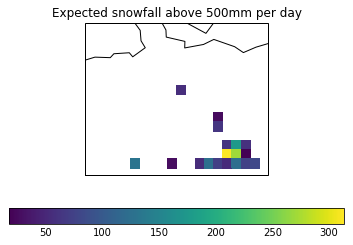

In [54]:
qplt.pcolormesh(es)
plt.gca().coastlines()
plt.show()

In [55]:
# define boxes for northern america and northern europe:

northern_america = (-140,30,-50,60)

northern_europe = (-25,42,44,68)

arealist = {}
arealist['NORTHERN AMERICA']=northern_america
arealist['NORTHERN EUROPE']=northern_europe
# define dictionary to save analysis results 
results = {}

In [56]:
def multi_region_threshold_analysis_preindustrial(modellist,arealist,intensity=True):

    for i_model in tqdm(modellist):
        for i_key in tqdm(arealist.keys()):
            results [i_model,'preindustrial',i_key] = comparison_threshold(i_model,cubelist,8,arealist[i_key],1851,2021,i_key,intensity=True)
            filename = str(i_model)+'preindustrial_'+str(i_key)
            date = datetime.datetime.now().strftime("%Y%m%d_%H:%M:%S")
            filename = filename+str(date)
            print(filename) 
            file = open(filename, 'wb')
            pickle.dump(results,file)                                            
   

In [57]:
import pickle


In [58]:
import datetime
# use pickle to store intermiedate results
date = datetime.datetime.now().strftime("%Y%m%d_%H:%M:%S")
filename = 'comparison_preindustrial_'+str(date)
print(filename)

comparison_preindustrial_20200408_11:25:55


In [59]:
# set outputpath for analyis pickle files etc

outputdir = '/p/tmp/quante/snow_simulation_data/notebook_output'
os.chdir(outputdir)


In [ ]:
# generate data for all models
multi_region_threshold_analysis_preindustrial (modellist,arealist)

 50%|█████     | 1/2 [29:35<29:35, 1775.86s/it]

gfdl-esm4preindustrial_NORTHERN AMERICA20200408_11:57:12



  0%|          | 0/2 [00:00<?, ?it/s]

gfdl-esm4preindustrial_NORTHERN EUROPE20200408_12:18:29
ipsl-cm6a-lrpreindustrial_NORTHERN AMERICA20200408_12:46:59



 50%|█████     | 1/2 [28:29<28:29, 1709.72s/it]

ipsl-cm6a-lrpreindustrial_NORTHERN EUROPE20200408_13:08:43



  0%|          | 0/2 [00:00<?, ?it/s]

mpi-esm1-2-hrpreindustrial_NORTHERN AMERICA20200408_13:36:58



 50%|█████     | 1/2 [28:15<28:15, 1695.15s/it]

mpi-esm1-2-hrpreindustrial_NORTHERN EUROPE20200408_13:57:48



  0%|          | 0/2 [00:00<?, ?it/s]

In [65]:
print(results[('gfdl-esm4', 'preindustrial', 'NORTHERN AMERICA')][('historical', 1851, 1860)]['map_cubes'].keys())

dict_keys([('500', 'frequency'), ('500', 'expected_snowfall'), ('500', 'intensity'), ('750', 'frequency'), ('750', 'expected_snowfall'), ('750', 'intensity'), ('1000', 'frequency'), ('1000', 'expected_snowfall'), ('1000', 'intensity'), ('1250', 'frequency'), ('1250', 'expected_snowfall'), ('1250', 'intensity'), ('1500', 'frequency'), ('1500', 'expected_snowfall'), ('1500', 'intensity')])


In [13]:
# function to restrict cubes on bounding box
from country_bounding_boxes import (
      country_subunits_containing_point,
      country_subunits_by_iso_code
    )
def cube_from_bounding_box (cube, bounding_box):
    return cube.intersection(longitude=(bounding_box[0],bounding_box[2])).intersection(latitude=(bounding_box[1],bounding_box[3]))


def country_dict_from_iso(country):
    country_dict = {}
    for c in country_subunits_by_iso_code(country):
        print (c.name)
        country_dict[str(c.name)]=c.bbox
    return country_dict



# method to create list of country limited cubes

def country_cubelist(cubelist,country_box):
    country_cubes = iris.cube.CubeList()
    for i_cube in cubelist:
        country_cubes.append(cube_from_bounding_box(i_cube,country_box))
    return unify_concatenate(country_cubes)
        
# filter all scenarios:
def country_filter(cubedict,country_box):
    dict_keys = cubedict.keys()
    country_cubes = {}
    for i_key in dict_keys:
        country_cubes[i_key] = country_cubelist(cubedict[i_key],country_box)
    return country_cubes

In [14]:
germany_box = country_dict_from_iso ('DE') ["Germany"]

Germany


In [8]:
print(germany_box
     )

(5.85751953125, 47.2788085938, 15.0166015625, 55.0587402344)
